In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import dsntnn

In [2]:
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'orange', 'brown', 'pink', 'purple', 'white', 'gray', 'olive']
cmap = sns.cubehelix_palette(start=3, rot=-1, hue=1.4, gamma=0.8, as_cmap=True)

# Inputs

In [4]:
predictions = np.load('../outputs/aug_preds.npz')
ids, coords, dists, labels = predictions.values()
ids.shape, coords.shape, dists.shape, labels.shape

((46,), (46, 13), (46, 13, 512, 1), (46, 13))

In [5]:
def format_preds(ids, coords, dists, labels):
    pred_dict = {}
    for i, name in enumerate(ids):
        tmp = coords[i]
        mask = labels[i]
        pred_dict[name] = {}
        for idx in range(len(mask)):
            if mask[idx] == 1:
                vert = ordered_verts[idx]
                coord = dsntnn.normalized_to_pixel_coordinates(tmp[idx], size=dists.shape[-2])
                pred_dict[name][vert] = coord
            else:
                continue
                
    dist_dict = {}
    for i, name in enumerate(ids):
        dist_dict[name] = dists[i, ..., 0]
        
    label_dict = {name: labels[i] for i, name in enumerate(ids)}
    return pred_dict, dist_dict, label_dict

In [6]:
pred_dict, dist_dict, label_dict = format_preds(ids, coords, dists, labels)

In [7]:
from ast import literal_eval

In [8]:
pix_info = pd.read_csv(f'../images_sagittal/annotation_info.csv', index_col='Name')
pix_info.head()

,Padding,Pixel Scaling
Name,,
03_06_2014_389_Sag,"(42.0, 42.0)","(1.1640625, 1.1640625)"
03_06_2014_402_Sag,"(-96.0, -96.0)","(0.625, 0.625)"
03_06_2014_396_Sag,"(-63.0, -63.0)","(0.75200004576, 0.75200004576)"
03_06_2014_395_Sag,"(-90.0, -90.0)","(0.6480000019200001, 0.6480000019200001)"
03_06_2014_399_TS_Sag,"(-96.0, -96.0)","(0.625, 0.625)"


# Get Ground-Truth

In [47]:
def get_gt(id_):
    path = f'../data/testing/targets/'
    #image
    img_path = f'../data/testing/slices/sagittal/{id_}.npy'
    img = np.load(img_path)
    # Coordinates
    coord_path = path + f'coordinates/{id_}.csv'
    coords = pd.read_csv(coord_path, index_col='Level').sort_values(by='Coordinate')
    # Heatmaps
    dist_path = path + f'heatmaps/{id_}.npy'
    dists = np.load(dist_path)
    return coords, dists, img

In [10]:
coord_dict = {}
for name in ids:
    coords, dists, img = get_gt(name)
    coord_dict[name] = coords

In [11]:
def make_labels(coord_dict):
    # Use halfway point between neighbouring levels as boundary
    # Coord dict=  patient specific coordinates
    gt_dict = {}
    for i, (level, data) in enumerate(coord_dict.iterrows()):
        coord = data.to_list()[0]
        dif = coord_dict['Coordinate']-coord
        if i ==0:
            nn = coord_dict.iloc[(dif).abs().argsort()[1]]
            dist = np.abs(dif[nn.name])
            range_ = [coord-dist/2, coord, coord+dist/2]
            gt_dict[level] = range_
        elif i > 0 and i < len(coord_dict.index)-1:
            nn = coord_dict.iloc[(dif).abs().argsort()[1:3]]
            for vert in nn.index.to_list():
                rel_dist = ordered_verts.index(vert)-ordered_verts.index(level)
                if rel_dist < 0:
                    up_nn = np.abs(dif[vert])
                elif rel_dist > 0:
                    down_nn = np.abs(dif[vert])
                else:
                    print('Indexing has gone wrong')
                    break
            range_ = [coord - up_nn/2, coord, coord + down_nn/2]
            gt_dict[level] = range_
        else:
            nn = coord_dict.iloc[(dif).abs().argsort()[1]]
            dist = np.abs(dif[nn.name])
            range_ = [coord - dist/2, coord, coord+dist/2]
            gt_dict[level] = range_
    return gt_dict

#### Make labels (range = dist. to NN/2)

Each entry: Min Range, Center point, Max Range

In [48]:
all_gt = {}
for name in ids:
    gt_dict = make_labels(coord_dict[name])
    all_gt[name] = gt_dict

# Make scores

In [13]:
def get_scores(name, pred_dict, label_dict, plot=False):
    if plot:
        plot_preds(name, pred_dict)
    #Inputs are patient-specific
    gt, pred, labels = all_gt[name], pred_dict[name], label_dict[name]
    img = np.load(f'../data/testing/slices/sagittal/{name}.npy')
    plot_gt = np.zeros((512, 512), dtype=np.uint8)
    level_list = []
    correct_list = []
    dist_list = []
    range_list = []
    for i, (level, range_) in enumerate(gt.items()):
        channel = ordered_verts.index(level)
        min_range, center, max_range = range_
        if labels[i]== 0:
            continue
        pred_coord = pred[level]
        if pred_coord > min_range and pred_coord < max_range:
            level_list.append(level)
            correct_list.append(True)
            dist = np.abs(pred_coord - center)
            pix_scale = literal_eval(pix_info.loc[name, 'Pixel Scaling'])
            dist /= pix_scale[0]            
            dist_list.append(dist)
            range_list.append(pix_scale[0]*np.abs(max_range-min_range))
        else:
            level_list.append(level)
            correct_list.append(False)
            dist = np.abs(pred_coord - center)
            pix_scale = literal_eval(pix_info.loc[name, 'Pixel Scaling'])
            dist /= pix_scale[0]
            dist_list.append(dist)
            range_list.append(pix_scale[0]*np.abs(max_range-min_range))
    return level_list, correct_list, dist_list, range_list

Automate making dataframe w/ scores

In [14]:
def make_score_df(pred_dict, label_dict):
    levels = []
    correct = []
    distances = []
    range_list = []
    for name in ids:
        level, cor, dist, ranges = get_scores(name, pred_dict, label_dict, plot=False)
        levels.extend(level)
        correct.extend(cor)
        distances.extend(dist)
        range_list.extend(ranges)
    scores_df = pd.DataFrame(columns=['Level', 'Correct', 'Distance', 'Range'])
    scores_df['Level'] = levels
    scores_df['Correct'] = correct
    scores_df['Distance'] = distances
    scores_df['Range'] = range_list
    scores_df.head()
    scores_df['Level'] = pd.Categorical(scores_df['Level'],
                                   categories=ordered_verts,
                                   ordered=True)
    table = pd.DataFrame(scores_df.groupby('Level')['Correct'].value_counts(normalize=True)*100).transpose()
    table.index = ['Accuracy']
    display(table)
    accuracy = {level: table[level, True] for level in ordered_verts}
    accuracy = pd.DataFrame(accuracy).T
    return scores_df, accuracy

# Plots

In [15]:
def plot_distances_w_acc(scores, accuracy):
    plt.style.use('seaborn-bright')
    fig, ax = plt.subplots(1, 1,figsize=(20, 10))

    sns.color_palette("hls", 2)
    sns.boxplot(data=scores, x='Level', y='Distance', hue='Correct', linewidth=1.5,  order=ordered_verts, palette='muted', ax=ax)
    g = sns.lineplot(data=scores, x= 'Level', y='Range', ci='sd', err_style="band", estimator='min', ax=ax, color='gray')
    ax.set_ylabel('Absolute distance to center ($mm$)')
    ax2 = ax.twinx()
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_ylim([-0.2, 100.2])
    sns.lineplot(data=accuracy, x=accuracy.index, y='Accuracy', ax=ax2, legend=False, ls='--', lw=3, color='limegreen' )
    #sns.catplot(dara=scores_df, x='Level', y=, hue='Correct', kind='hist')
    g.grid(True, which='both')
    #g.axhline(y=0, color='k')


    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 4 each.
    handles, labels = g.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the last two.
    l = ax.legend(handles[0:2], labels[0:2], loc='upper left')

    ax2.spines['right'].set_color('limegreen')
    #ax2.yaxis.label.set_color('limegreen')
    ax2.tick_params(axis='y', colors='limegreen')
    l.get_texts()[0].set_text('Incorrect')
    l.get_texts()[1].set_text('Correct')

# Heatmaps

In [16]:
from scipy.ndimage import zoom

In [17]:
def plot_heatmap(dist_dict, name):
    dist = dist_dict[name]
    dist = zoom(input=dist, zoom=(10, 1), order=1)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(dist.T, cmap=cmap)

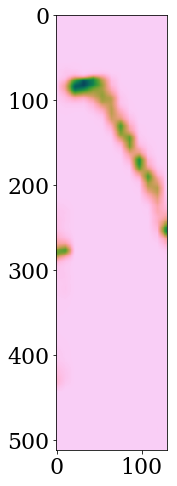

In [18]:
plot_heatmap(dist_dict, ids[7])

In [19]:
import scipy.optimize as opt
import sys

In [20]:
def func(x, a, b, c):
    return a + b*x + c*x**2

(350, 3)


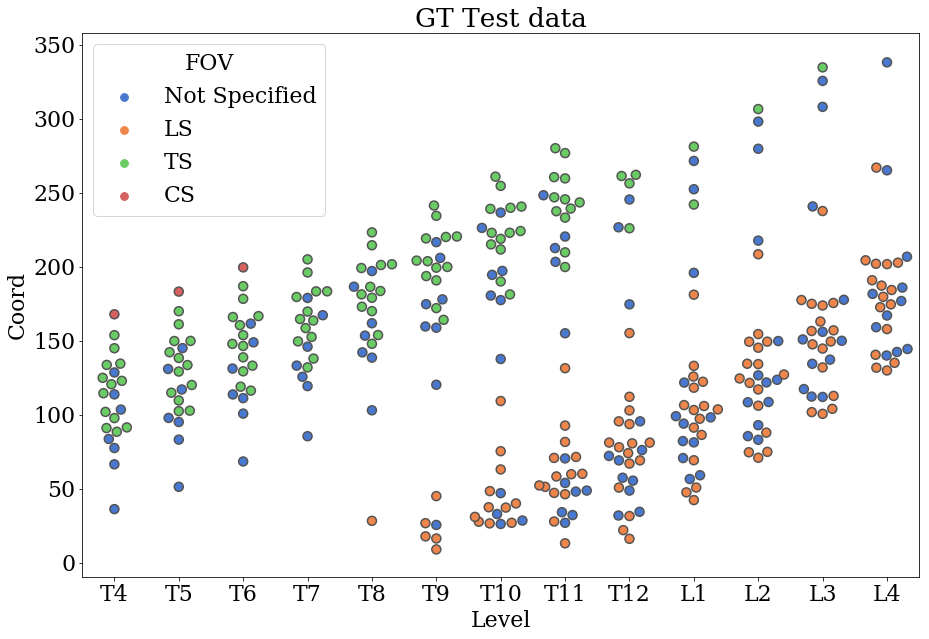

In [50]:
level = []
coord = []
fov = []
for name, gt in all_gt.items():
    for vert, y in gt.items():
        level.append(vert)
        pad,  _ = literal_eval(pix_info.loc[name][0])
        coord.append(y[1]+pad)
        if 'TS' in name:
            fov.append('TS')
        elif 'LS' in name:
            fov.append('LS')
        elif 'CS' in name:
            fov.append('CS')
        else:
            fov.append('Not Specified')

gt_df = pd.DataFrame(columns=['Level', 'Coord'])
gt_df['Level'] = level
gt_df['Coord'] = coord
gt_df['FOV'] = fov
print(gt_df.shape)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_title('GT Test data')
sns.swarmplot(data=gt_df, x='Level', y ='Coord', hue='FOV', order=ordered_verts, s=9, linewidth=1.5, palette='muted')

In [98]:
def linear_expectation(probs, values):
    # Assumes normalised probs + single channel
    expectation = []
    for i in range(len(values)):
        expectation.append(probs[i]*values[i])
    return np.sum(expectation)

In [139]:
def fit_max(dist_dict, label_dict, name, plot=False):
    eps=1e-24
    dist = dist_dict[name]
    x = np.linspace(0, dist.shape[1], num=dist.shape[1])
    label = label_dict[name]
    gt = []
    for level in ordered_verts:
        if level in all_gt[name].keys():
            gt.append(all_gt[name][level][1])
        else:
            gt.append(0)
    
    max_ = [linear_expectation(dist[i], x) for i in range(dist.shape[0])]
    argmax = [int(x) for x in max_]
    conf = np.var(dist, axis=1)
    
    updated_points = []
    norm_dist = dist/(np.sum(dist, axis=0)+eps)
    for i in range(norm_dist.shape[0]):
        upd_dist = dist[i]*norm_dist[i]**2
        upd_dist /= np.sum(upd_dist)
        updated_points.append(linear_expectation(upd_dist, x))
        
    x = np.arange(0, len(max_))
    data = {'X': x, 'Y': max_, 'Label':label, 'Conf': conf, 'GT': gt, 'Update': updated_points}
    points = pd.DataFrame(data)
    fit_data = points.loc[points['Label'] == 1].copy()
    x0    = np.array([0.0, 0.0, 0.0])
    params, cov = opt.curve_fit(func, fit_data['X'].values, 
                  fit_data['Y'].values, x0, sigma=fit_data['Conf'].values, absolute_sigma=True)
    param_dict= {'Params': params, 'Cov': cov}
    sample=[func(x, *params)for x in fit_data['X'].values]    
    if plot:
        fit_data['Sample'] = sample
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        plt.plot(x, func(x, *params))
        sns.scatterplot(data=points, x='X', y='Update', marker='X', s=120, linewidth=1.5, edgecolor='k', label='Updated')
        sns.scatterplot(data=points, x='X', y='GT', marker='^', s=120, linewidth=1.5, edgecolor='k', label='Ground-Truth')
        sns.scatterplot(data=fit_data, x='X', y='Sample', s=200, linewidth=1.5, edgecolor='k', marker='*', label='Sampled from Fit')
        sns.scatterplot(data=points, x='X', y='Y', hue='Label', s=100, linewidth=1.5, edgecolor='k', marker='o', label='Predictions', legend=False)
        ax.set_xlabel('Level')
        ax.legend(bbox_to_anchor=(1, 1))
    
    sample_dict = {ordered_verts[idx]: x for x, idx in zip(sample, fit_data.index)}
    return param_dict, sample_dict

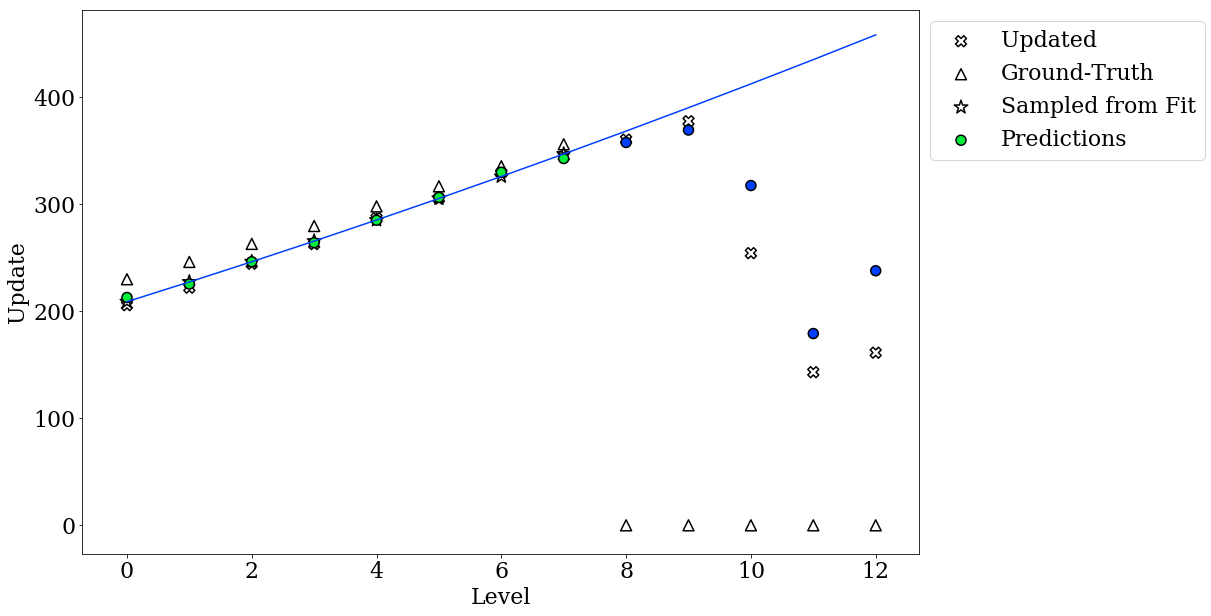

In [144]:
param_dict, sample = fit_max(dist_dict, label_dict, ids[13], plot=True)

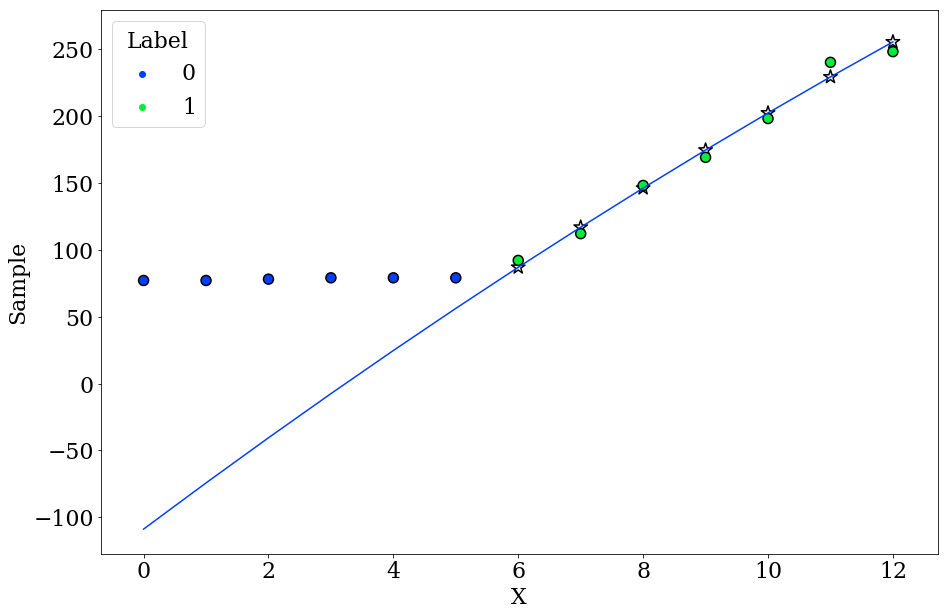

In [52]:
sample_dict = {}
for name in ids:
    param_dict, sample = fit_max(dist_dict, label_dict, name, plot=True)
    sample_dict[name] = sample
    break

(350, 2)


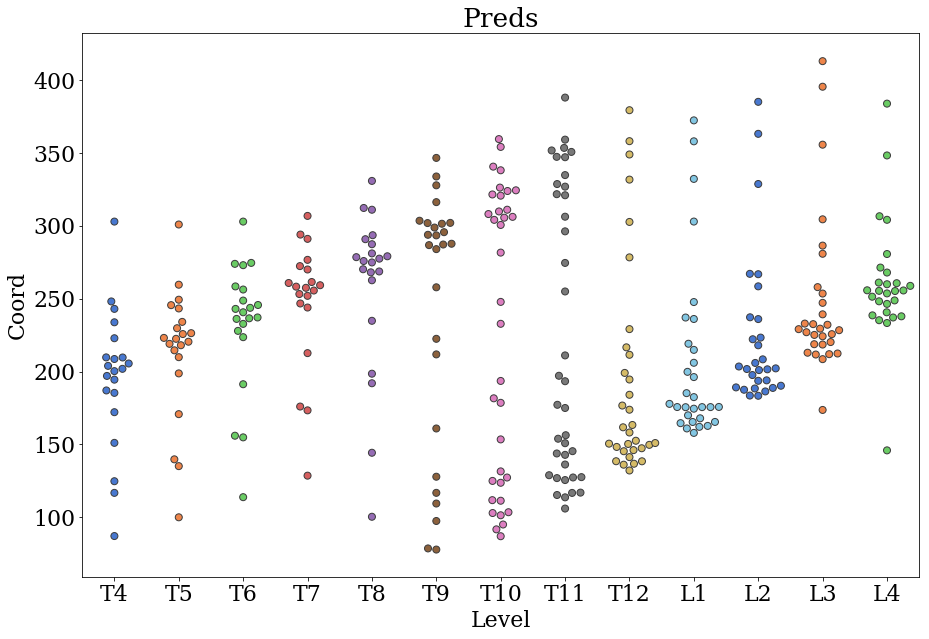

In [51]:
level_list, coord_list = [], []
for name, sample in sample_dict.items():
    for level, coord in sample.items():
        level_list.append(level)
        coord_list.append(coord)
sample_df = pd.DataFrame(columns=['Level', 'Coord'])
sample_df['Level'] = level_list
sample_df['Coord'] = coord_list
print(sample_df.shape)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_title('Preds')
sns.swarmplot(data=sample_df, x='Level', y='Coord', order=ordered_verts, s=7, linewidth=1,palette='muted')

## Update points 

In [25]:
scores, accuracy = make_score_df(pred_dict, label_dict)

Level           T4                    T5                    T6              \
Correct       False      True       False      True       True       False   
Accuracy  57.142857  42.857143  61.904762  38.095238  61.904762  38.095238   

Level      T7          T8         ...   T12              L1               L2   \
Correct  True  False True  False  ... True  False      True       False True    
Accuracy  60.0  40.0  55.0  45.0  ...  75.0  25.0  66.666667  33.333333  70.0   

Level            L3               L4              
Correct  False True  False      True       False  
Accuracy  30.0  70.0  30.0  58.823529  41.176471  

[1 rows x 26 columns]

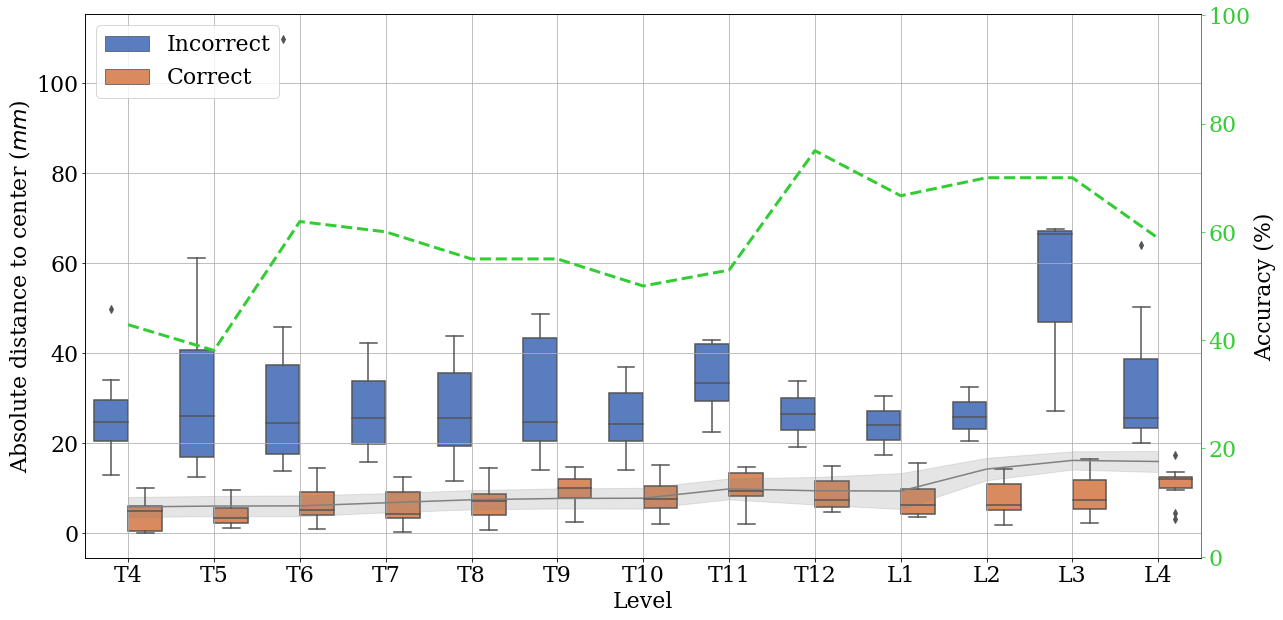

In [26]:
plot_distances_w_acc(scores, accuracy)

In [27]:
fit_scores, fit_acc = make_score_df(sample_dict, label_dict)

Level           T4                    T5                    T6              \
Correct       False      True       False      True       False      True    
Accuracy  61.904762  38.095238  52.380952  47.619048  57.142857  42.857143   

Level      T7          T8         ...   T12         L1          L2         \
Correct  False True  False True   ... False True  False True  True  False   
Accuracy  55.0  45.0  50.0  50.0  ...  62.5  37.5  50.0  50.0  70.0  30.0   

Level      L3               L4              
Correct  True  False      True       False  
Accuracy  70.0  30.0  76.470588  23.529412  

[1 rows x 26 columns]

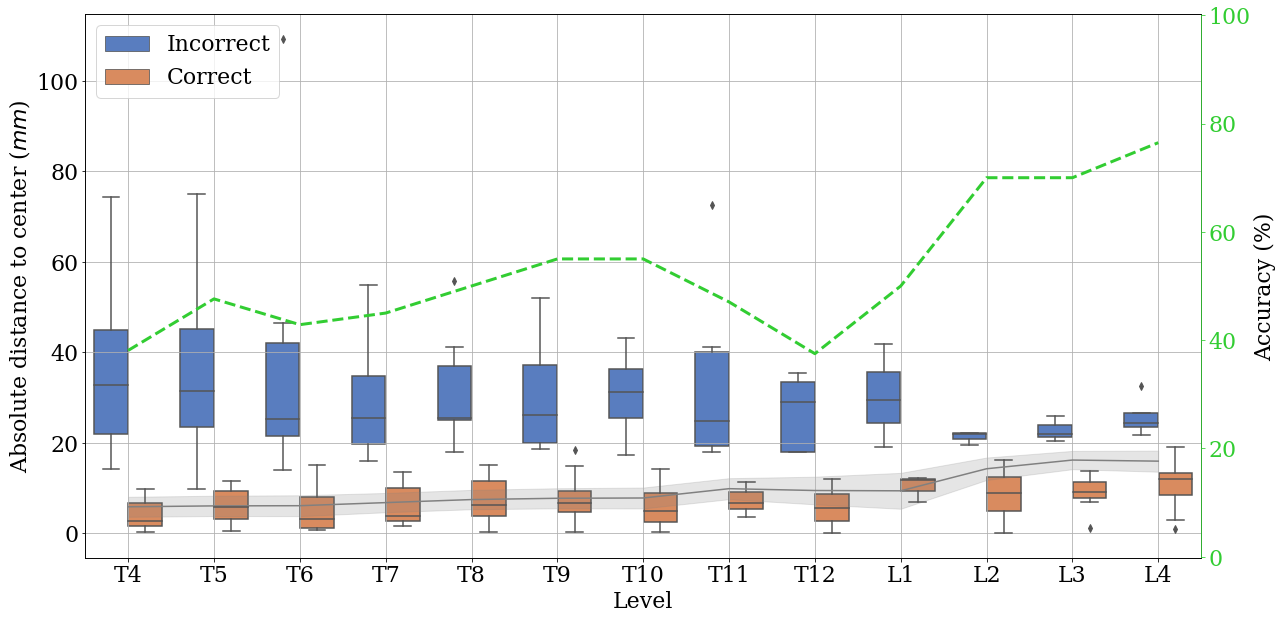

In [28]:
plot_distances_w_acc(fit_scores, fit_acc)